In [12]:
import nltk
from time import time
import matplotlib.pyplot as plt
import torch
from glob import glob
import pandas as pd

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ccaban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Dataset

In [9]:
subtitles_paths = sorted(glob('../data/Subtitles/*.ass'))

In [10]:
scripts = []
episode_num = []
for path in subtitles_paths:
    with open(path, 'r') as file:
        lines = file.readlines()
        lines = lines[27:]
        rows = [",".join(line.split(',')[9:]) for line in lines]
    rows = [line.replace("\\N", ' ') for line in rows]
    script = " ".join(rows)
    episode = int(path.split('-')[1].split('.')[0].strip())
    scripts.append(script)
    episode_num.append(episode)

In [13]:
df = pd.DataFrame.from_dict({'episode': episode_num, 'script': scripts})
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


## Load Model

In [14]:
device = 0 if torch.cuda.is_available() else 'cpu'

In [17]:
from transformers import pipeline
theme_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [18]:
theme_classifier("I have a problem with my iphone that needs to be resolved asap!", candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"], multi_label=False)

{'sequence': 'I have a problem with my iphone that needs to be resolved asap!',
 'labels': ['urgent', 'phone', 'computer', 'not urgent', 'tablet'],
 'scores': [0.5227581858634949,
  0.4581397771835327,
  0.014264918863773346,
  0.002685003448277712,
  0.002152077853679657]}

## Inference

In [29]:
from nltk import sent_tokenize
import numpy as np

def get_themes(script):
    script_sentences = sent_tokenize(script)

    # Batch sentences
    script_batches = []
    sentence_batch_size = 20
    for index in range(0, len(script_sentences), sentence_batch_size):
        script_batches.append(" ".join(script_sentences[index:index + sentence_batch_size]))
    
    # Run Model
    candidate_labels = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue"]
    emotion_output = theme_classifier(script_batches, candidate_labels=candidate_labels, multi_label=True)

    # Wrangle Output
    emotions = {}
    for output in emotion_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in emotions:
                emotions[label] = []
            else:
                emotions[label].append(score)
    emotions = {key: np.mean(np.array(value)) for key, value in emotions.items()}

    return emotions

In [30]:
output_emotions = df['script'].apply(get_themes)

In [32]:
emotion_df = pd.DataFrame(output_emotions.tolist())
emotion_df.head()

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.929708,0.836561,0.721848,0.739128,0.790847,0.368039,0.285855,0.180347
1,0.875023,0.559288,0.627566,0.557175,0.743586,0.365536,0.209769,0.109749
2,0.908166,0.598867,0.694666,0.708142,0.729209,0.357725,0.338572,0.223328
3,0.685411,0.316458,0.627644,0.469560,0.478200,0.208440,0.083990,0.103677
4,0.813044,0.668059,0.749821,0.708210,0.662926,0.315102,0.249769,0.115046


In [33]:
df[emotion_df.columns] = emotion_df

In [36]:
theme_output = df.drop(['episode', 'script', 'dialogue'], axis=1).sum().reset_index()
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,123.582282
1,battle,154.016707
2,sacrifice,155.469732
3,self development,143.148466
4,hope,88.210768
5,friendship,74.279722
6,love,44.489095


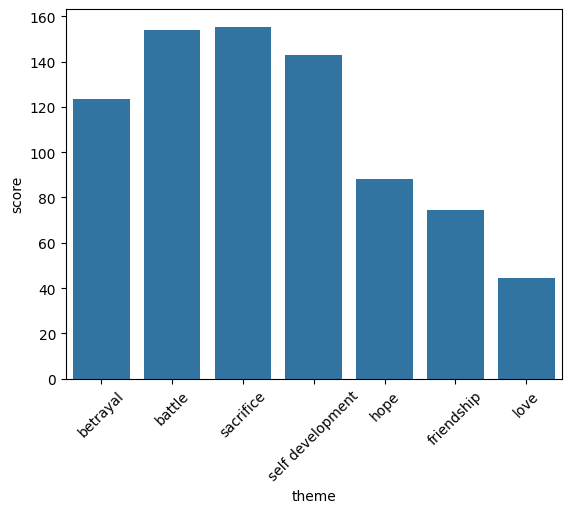

In [39]:
import seaborn as sns
sns.barplot(data=theme_output, x='theme', y='score')
plt.xticks(rotation=45)
plt.show()